In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [2]:
df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/ESM4/node_files/SH_SN.csv', delimiter='\t')

In [3]:
def assign_sh_season(row):
    month = row['Month']
    year = row['Year']
    if month in [10,11,12]:
        return pd.Series({'Season': 'summer', 'SeasonYear': year + 1})
    elif month in [1, 2, 3]:
        return pd.Series({'Season': 'summer', 'SeasonYear': year})
    elif month in [4, 5, 6, 7, 8, 9]:
        return pd.Series({'Season': 'winter', 'SeasonYear': year})
    
df[['Season', 'SeasonYear']] = df.apply(assign_sh_season, axis=1)

In [4]:
df.loc[df['Month'].isin(range(10)), 'SeasonYear'] = df['Year']
df.loc[df['Month'].isin([10,11,12]), 'SeasonYear'] = df['Year'] + 1
df

,Event,Year,Month,Day,Time,Lon,Lat,SLP,Windspeed,Season,SeasonYear
0,1,1,1,1,6,61.875,-52.5,97253.26,18.92103,summer,1.0
1,1,1,1,1,12,63.125,-55.5,97056.53,20.13886,summer,1.0
2,1,1,1,1,18,63.125,-58.5,97113.02,19.76665,summer,1.0
3,1,1,1,2,0,61.875,-59.5,96797.90,16.56477,summer,1.0
4,1,1,1,2,6,59.375,-60.5,96603.87,17.29902,summer,1.0
...,...,...,...,...,...,...,...,...,...,...,...
901786,48732,100,12,31,0,208.125,-59.5,97451.93,14.46151,summer,101.0
901787,48732,100,12,31,6,213.125,-60.5,97489.36,14.13835,summer,101.0
901788,48732,100,12,31,12,218.125,-61.5,97586.23,14.61312,summer,101.0
901789,48732,100,12,31,18,224.375,-62.5,97798.56,13.76056,summer,101.0


In [6]:
df_winter = df[df['Month'].isin([4,5,6,7,8,9])]
df_summer = df[df['Month'].isin([1,2,3,10,11,12])]

In [7]:
year_counts_winter = df_winter['SeasonYear'].value_counts().sort_index()
year_counts_summer = df_summer['SeasonYear'].value_counts().sort_index()

year_counts_winter.index = year_counts_winter.index.astype(int)
year_counts_summer.index = year_counts_summer.index.astype(int)

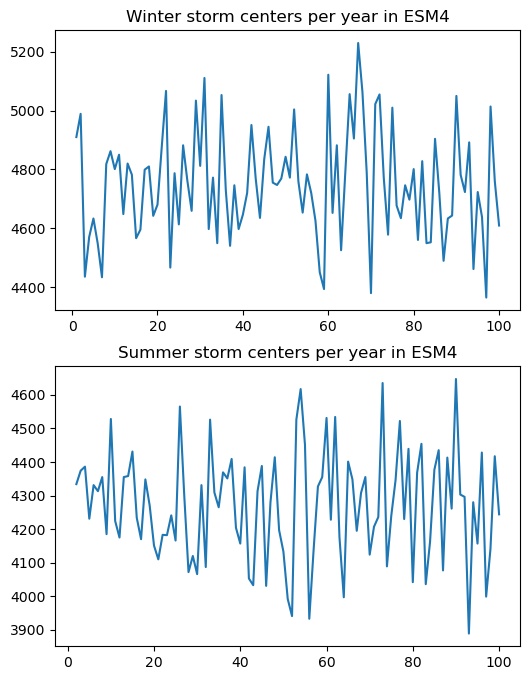

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,8))

year_counts_winter.plot(ax=axs[0])
axs[0].set_title('Winter storm centers per year in ESM4')

year_counts_summer[1:-1].plot(ax=axs[1])
axs[1].set_title('Summer storm centers per year in ESM4')

plt.savefig('/home/Katherine.Turner/Figures/ESM4_storm_activity_seasonal.png', format='png', dpi=100)

In [10]:
np.corrcoef(year_counts_winter[1:], year_counts_summer[1:-1])

array([[1.        , 0.05088483],
       [0.05088483, 1.        ]])

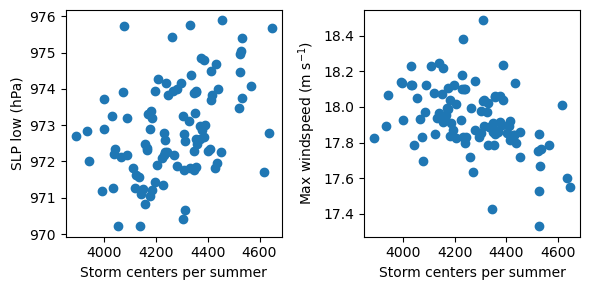

In [11]:
event_counts = np.zeros(len(year_counts_summer[1:-1]))
mean_slp = np.zeros(len(year_counts_summer[1:-1]))
mean_windmax = np.zeros(len(year_counts_summer[1:-1]))
for i, year in enumerate(year_counts_summer[1:-1].index):
    event_counts[i] = len(df_summer[df_summer['SeasonYear'] == year]['Event'].value_counts())
    mean_slp[i] = df_summer[df_summer['SeasonYear'] == year]['SLP'].mean()
    mean_windmax[i] = df_summer[df_summer['SeasonYear'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_summer[1:-1], 1e-2*mean_slp)
axs[1].scatter(year_counts_summer[1:-1], mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per summer')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per summer')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [13]:
print(np.corrcoef(year_counts_summer[1:-1], mean_slp)[0,1])
print(np.corrcoef(year_counts_summer[1:-1], mean_windmax)[0,1])

0.3922327760965469
-0.4300852598551222


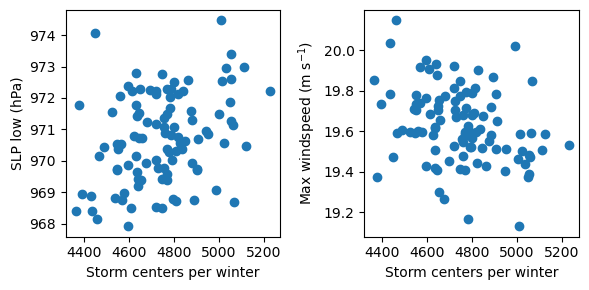

In [14]:
event_counts = np.zeros(len(year_counts_winter))
mean_slp = np.zeros(len(year_counts_winter))
mean_windmax = np.zeros(len(year_counts_winter))
for i, year in enumerate(year_counts_winter.index):
    event_counts[i] = len(df_winter[df_winter['Year'] == year]['Event'].value_counts())
    mean_slp[i] = df_winter[df_winter['Year'] == year]['SLP'].mean()
    mean_windmax[i] = df_winter[df_winter['Year'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_winter, 1e-2*mean_slp)
axs[1].scatter(year_counts_winter, mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per winter')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per winter')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [33]:
low_years = year_counts_summer[1:-1].sort_values()[:7].sort_index().index
high_years = year_counts_summer[1:-1].sort_values()[-7:].sort_index().index

In [27]:
year_counts_winter.values

array([4910, 4989, 4435, 4570, 4633, 4548, 4433, 4818, 4862, 4801, 4850,
       4648, 4820, 4782, 4566, 4595, 4799, 4810, 4642, 4680, 4877, 5067,
       4466, 4787, 4613, 4882, 4761, 4659, 5034, 4812, 5111, 4597, 4772,
       4549, 5053, 4729, 4540, 4746, 4597, 4646, 4720, 4951, 4769, 4635,
       4835, 4945, 4755, 4747, 4769, 4843, 4772, 5004, 4759, 4653, 4783,
       4720, 4625, 4450, 4393, 5122, 4652, 4882, 4525, 4794, 5056, 4905,
       5230, 5063, 4789, 4379, 5022, 5055, 4770, 4578, 5010, 4677, 4634,
       4746, 4697, 4801, 4560, 4828, 4549, 4552, 4904, 4720, 4489, 4633,
       4643, 5050, 4781, 4723, 4892, 4461, 4723, 4638, 4364, 5014, 4759,
       4609])

In [34]:
high_years, low_years

(Int64Index([10, 26, 54, 60, 62, 73, 90], dtype='int64'),
 Int64Index([46, 51, 52, 56, 64, 93, 97], dtype='int64'))

In [39]:
high_years, low_years

(Int64Index([22, 31, 60, 65, 67, 68, 72], dtype='int64'),
 Int64Index([3, 7, 58, 59, 70, 94, 97], dtype='int64'))

In [35]:
year_counts_summer[1:-1].sort_values()[:7].sum(), year_counts_summer[1:-1].sort_values()[-7:].sum()

(27782, 32057)

In [29]:
ds_mask = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas/masked*.nc', use_cftime=True)
da = ds_mask.resample(time='QS-DEC').sum()

In [36]:
winter_months = 6
summer_months_p1 = [10,11,12]
summer_months_p2 = [1,2,3]

idx_hi_mask = (ds_mask.time.dt.year.isin(high_years-1) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(high_years) & ds_mask.time.dt.month.isin(summer_months_p2)) 
idx_low_mask = (ds_mask.time.dt.year.isin(low_years-1) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(low_years) & ds_mask.time.dt.month.isin(summer_months_p2))

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


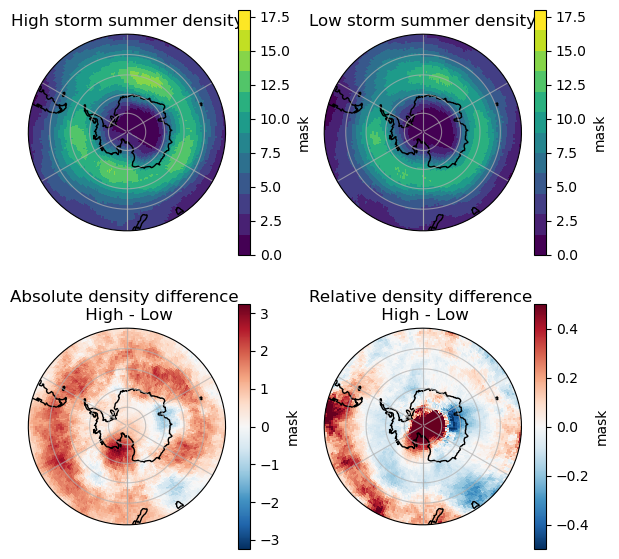

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7,7),
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(6*7) * ds_mask.mask[idx_hi_mask,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[0].set_title('High storm summer density')

(1/(6*7) * ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[1],
                                                                x='lon', y='lat',
                                                                transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[1].set_title('Low storm summer density')

(1/(6*7) * (ds_mask.mask[idx_hi_mask,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_mask,:,:].sum(dim='time'))).plot(ax=axs[2], 
                                                      x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

axs[2].set_title('Absolute density difference \n High - Low')

((1/32057 * ds_mask.mask[idx_hi_mask,:,:].sum(dim='time') - 
 1/27782 * ds_mask.mask[idx_low_mask,:,:].sum(dim='time')) / 
 (1/27782 * ds_mask.mask[idx_low_mask,:,:].sum(dim='time'))).plot(ax=axs[3],
                                                                  x='lon', y='lat', extend='neither',
                                                                  vmin=-.5, vmax=.5, cmap='RdBu_r',
                                                                  transform=ccrs.PlateCarree())
axs[3].set_title('Relative density difference \n High - Low')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

In [36]:
winter_months = [4, 5, 6, 7, 8, 9]
summer_months = [1, 2, 3, 10, 11, 12]

idx_hi_mask = ds_mask.time.dt.year.isin(high_years) & ds_mask.time.dt.month.isin(winter_months)
idx_low_mask = ds_mask.time.dt.year.isin(low_years) & ds_mask.time.dt.month.isin(winter_months)

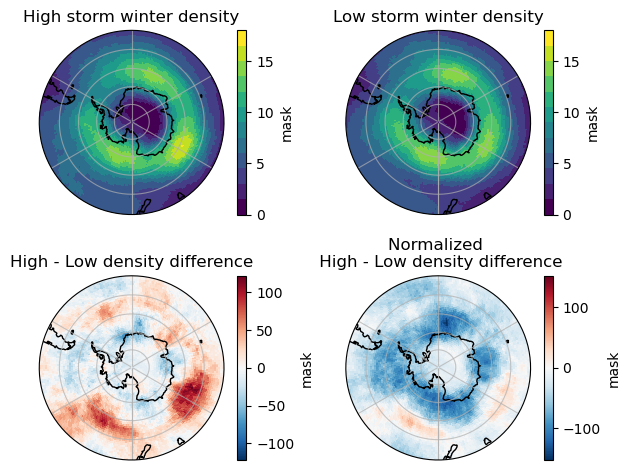

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(6*7) * ds_mask.mask[idx_hi_mask,:,:].sum(dim='time')).plot(ax=axs[0], x='lon', y='lat', 
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))
(1/(6*7) * ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[1], x='lon', y='lat', 
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

(ds_mask.mask[idx_hi_mask,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[2], x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

(27585/32689 * ds_mask.mask[idx_hi_mask,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_mask,:,:].sum(dim='time')).plot(ax=axs[3], x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

axs[0].set_title('High storm winter density')
axs[1].set_title('Low storm winter density')
axs[2].set_title('High - Low density difference')
axs[3].set_title('Normalized \n High - Low density difference')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.tight_layout()

## Can we create a timeseries of storm activity that looks more continuous?

In [14]:
atmos_static = xr.open_dataset('/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp/atmos/atmos.static.nc')

In [24]:
atmos = xr.open_dataset('/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp/atmos/ts/monthly/5yr/atmos.015101-015512.slp.nc', 
                        use_cftime=True)

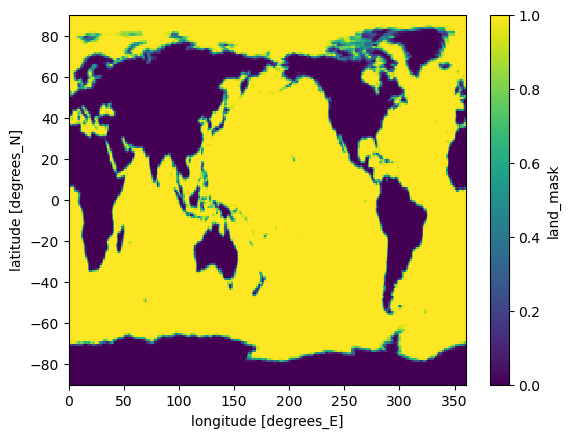

In [17]:
ocean_mask = 1-atmos_static.land_mask
ocean_mask.plot()

In [27]:
atmos.slp

<xarray.DataArray 'slp' (time: 60, lat: 180, lon: 288)>
[3110400 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0151-01-16 12:00:00 ... 0155-12-16 12:00:00
Attributes:
    units:          hPa
    long_name:      sea level pressure
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [31]:
dA = om4.standard_grid_cell_area(atmos.lat, atmos.lon)

In [18]:
ocean_storms = ds_mask.mask * ocean_mask

In [34]:
ocean_storm_area = (ocean_storms * dA).sum(dim=['lat', 'lon']).compute()
ocean_storm_area

<xarray.DataArray (time: 34675)>
array([0.00000000e+00, 7.61204287e+12, 7.61204287e+12, ...,
       1.03278528e+13, 3.89013927e+12, 3.89013927e+12])
Coordinates:
  * time     (time) object 0151-01-01 12:00:00 ... 0245-12-31 12:00:00

In [50]:
n_ocean_storm_area = (ocean_storm_area[10:-10] - ocean_storm_area[10:-10].mean())/(ocean_storm_area[10:-10].std())

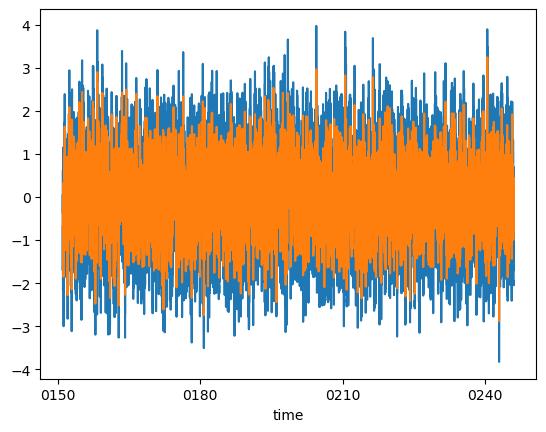

In [52]:
n_ocean_storm_area.plot()
n_ocean_storm_area.rolling(time=10, center=True).mean().plot()

/vftmp/Katherine.Turner/pid3506641/ipykernel_3602084/2653702836.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/f, Pxx_den)


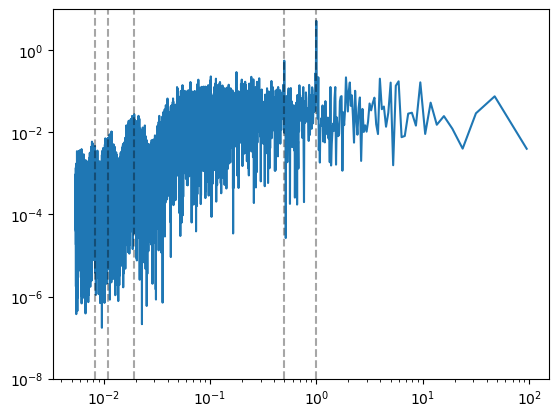

In [85]:
fs = 365
f, Pxx_den = signal.periodogram(n_ocean_storm_area, fs)

plt.loglog(1/f, Pxx_den)
plt.ylim([1e-8, 1e1])

plt.plot([1, 1], [1e-8, 1e1], 'k--', alpha=0.35)
plt.plot([1/2, 1/2], [1e-8, 1e1], 'k--', alpha=0.35)
plt.plot([1/52, 1/52], [1e-8, 1e1], 'k--', alpha=0.35)
plt.plot([4/365, 4/365], [1e-8, 1e1], 'k--', alpha=0.35)
plt.plot([3/365, 3/365], [1e-8, 1e1], 'k--', alpha=0.35)

#plt.xlabel('Frequency (cycles per year)')

In [113]:
df['doy'] = pd.to_datetime({'year': 2001, 'month': df['Month'], 'day': df['Day']}).dt.dayofyear
df['year_dec'] = df['Year'] + df['doy']/365

day_counts_6hr = df['year_dec'].value_counts().sort_index()

In [118]:
day_counts = 0.25 * day_counts_6hr.values[20:-20:4]

In [119]:
day_counts

array([5.25, 6.  , 4.25, ..., 3.25, 5.75, 6.75])

/vftmp/Katherine.Turner/pid3506641/ipykernel_3602084/870043174.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(1/f, Pxx_den)


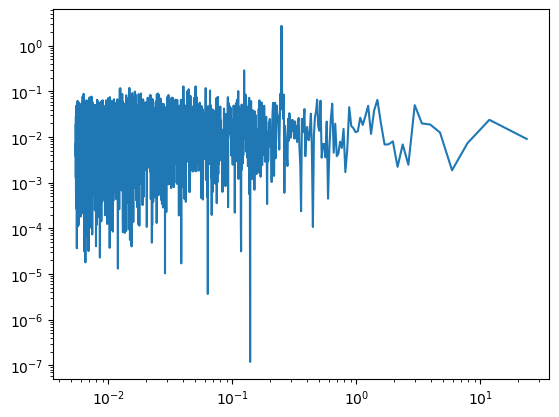

In [120]:
fs = 365
f, Pxx_den = signal.periodogram(day_counts, fs)

plt.loglog(1/f, Pxx_den)
#plt.ylim([1e-8, 1e1])

#plt.plot([1, 1], [1e-8, 1e1], 'k--', alpha=0.35)
#plt.plot([1/2, 1/2], [1e-8, 1e1], 'k--', alpha=0.35)
#plt.plot([1/52, 1/52], [1e-8, 1e1], 'k--', alpha=0.35)
#plt.plot([4/365, 4/365], [1e-8, 1e1], 'k--', alpha=0.35)
#plt.plot([3/365, 3/365], [1e-8, 1e1], 'k--', alpha=0.35)